## Import packages

In [1]:
import CairoMakie: activate!, Figure, Axis, GridLayout, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, contourf!, Colorbar, hist, hist!, contour!, heatmap!, image, image!, Outside,
poly!, hidedecorations!, hidespines!, Label, text!, colgap!, rowgap!, Outside, colsize!, rowsize!, Relative, AxisAspect, 
density!, qqplot!, linkxaxes!, linkyaxes!, BBox, translate!, TopLeft, Label, resize_to_layout!,
hidexdecorations!, hideydecorations!, Inside, Outside, Aspect, Observable, notify
import Makie.GeometryBasics: Rect
import Makie: available_gradients, pseudolog10, Reverse
import Measures: mm
import NaNStatistics: nanmedian, nanmaximum, nanminimum, nanmean, nanstd, movmean
import Distributed: addprocs, pmap, @everywhere
import Dates: now, Millisecond
import StatsBase: sample, mean, min, mode, fit, Histogram, std, quantile, median, skewness, kurtosis, max
import DataFrames: DataFrame, names, describe, append!, insertcols!, hcat!, groupby, combine, order, stack, unstack, order
import Distributions: Normal, cdf, ccdf, fit,fit_mle,Bernoulli,Beta,Binomial,Categorical,DiscreteUniform,Exponential,LogNormal,Normal,Gamma,Geometric,Laplace,Pareto,Poisson,Rayleigh,InverseGaussian,Uniform,Weibull
import Statistics: cor, quantile
import HypothesisTests: SignedRankTest, OneSampleTTest, UnequalVarianceTTest, EqualVarianceTTest, TwoSampleTTest, CorrelationTest, pvalue
import Printf: @sprintf
import Roots: find_zero, fzero, newton, Newton
import JLD: save, load
import CSV: write, read, File
import CurveFit: curve_fit, Polynomial, ExpFit, LogFit, PowerFit#, KingFit, LinearKingFit, LinearFit
#import Calculus: derivative
import ForwardDiff: derivative 
import NLsolve: nlsolve
using ProgressMeter
import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
colblue=palette(:default)[1];
#c=palette(:default); c = [c[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default),   #sunset,    # CMRmap  gnuplot magma plasma   thermal   linear_bmy_10_95_c78_n256 linear_bmy_10_95_c71_n256
    #Axis=(yticklabelsize=18, xticklabelsize=18,xlabelsize=20,ylabelsize=20),
    #Axis=(titlesize=24,),
    ))

In [2]:
findnearest(t::Number, A::AbstractArray) = findmin(abs.(A.-t))[2]; #find the position of t in A
findnearest(vec::AbstractArray, A::AbstractArray) = [findmin(abs.(A.-t))[2] for t in vec]; #find the positions of elements of vec in A

nanlength(x::AbstractVector) = length(x[.~isnan.(x)]);

## Phase transition lines

In [3]:
dT = 0.001; Tblue_max = 0.5;
Tblue = dT:dT:Tblue_max;
Fblue(T) = T*acosh((1-T)/T);
ηblue = Fblue.(Tblue);
Tbluemax = Tblue[findmax(ηblue)[2]]; ηbluemax = findmax(ηblue)[1];

function find_redline(T)  
    fv(T, η, v) = -v + 0.5*sinh(2*v/T)/(cosh(2*v/T) + cosh(η/T));
    dfdv_v(T, x) = [fv(T, x[1], x[2])
                    derivative(v -> fv(T, x[1], v), x[2])];
    xguess(T) = [1-T, 0.5 - T/8];
    return T < 0.0029 ? NaN : try nlsolve(x -> dfdv_v(T, x), xguess(T)).zero[1] catch y NaN end
end

FV(    T, η, V) = 1/2*sinh(2*V/T) / (cosh(2*V/T) + cosh(η/T)) - V;
dFdV(  T, η, V) = derivative(V->FV(T, η, V), V)
d2FdV2(T, η, V) = derivative(V->dFdV(T, η, V), V)
d3FdV3(T, η, V) = derivative(V->d2FdV2(T, η, V), V)

function find_3crit_point()
    #T, eta, V
    find_3crit(x) = [FV(x[1], x[2], x[3]), dFdV(x[1], x[2], x[3]), d3FdV3(x[1], x[2], x[3])];
    xguess = [0.32, Fblue(0.32), 0];
    critpoint = nlsolve(x -> find_3crit(x), xguess).zero;  
    Tcritpoint=critpoint[1]; ηcritpoint=critpoint[2]; Vcritpoint=critpoint[3];
    return Tcritpoint, ηcritpoint
end
function find_redline_full(Tred)
    Tcritpoint = find_3crit_point()[1];
    dV_redcrit = 10^(-2);
    #red line
    dfdv_v_redcritline(T, x) = [FV(T, x[1], x[2]), dFdV(T, x[1], x[2])];
    xguess_redcritline1(T) = [find_redline(T), 0.5 - T/8];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline1(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];  Tsol = Tred; 
    Tsol, etasol, vsol = Tsol[vsol .> dV_redcrit], etasol[vsol .> dV_redcrit], vsol[vsol .> dV_redcrit];
    xguess_redcritline(T) = [find_redline(T), vsol[findnearest(T, Tsol)]];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];
    ηred = etasol;
    return ηred
end

Tcritpoint, ηcritpoint = find_3crit_point()
Tred = Tblue[0.003 .≤ Tblue .≤ Tcritpoint];
ηred = find_redline_full(Tred);
Tcritpoint, ηcritpoint 

(0.33333333333333326, 0.43898596564160547)

## Load experimental data (Ratcliff 2016, 2008)

In [4]:
file_name="./05_data_RDM/A_accuracy_coherence";
df = DataFrame(File(file_name*".csv"));
accuracy_A  = df[:, 2]; coherence_A = df[:, 1];

file_name="./05_data_RDM/B_RTright_coherence";
df = DataFrame(File(file_name*".csv"));
RTright_B  = df[:, 2]; coherence_B = df[:, 1];

file_name="./05_data_RDM/C_meanRT_accuracy";
df = DataFrame(File(file_name*".csv"));
RTmean_C  = df[:, 2]; accuracy_C = df[:, 1];
df = nothing;

coherence = mean([coherence_A coherence_B], dims=2)[:];
accuracy = mean([accuracy_A accuracy_C], dims=2)[:];
RTmean = mean([RTright_B RTmean_C], dims=2)[:];

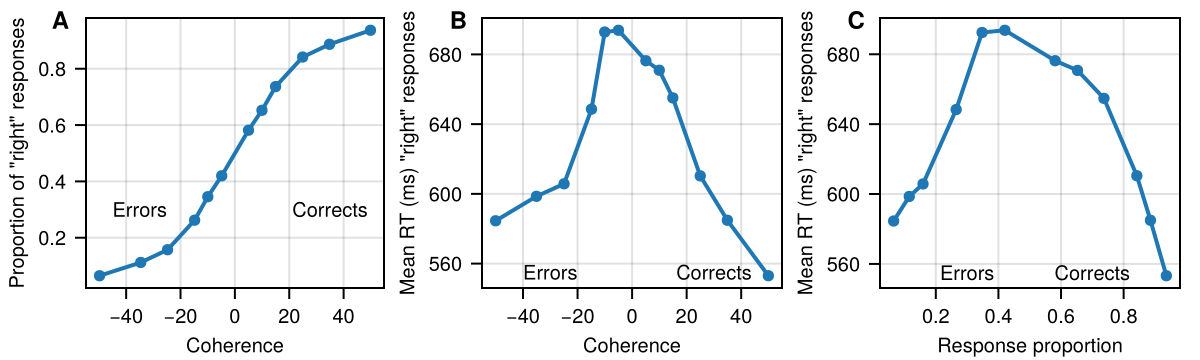

In [5]:
polyfit_power = 6;
fig = Figure(size=(600, 180), fontsize=10, figure_padding=(3, 10, 3, 3)); ax = []; 
    ga = fig[1,1] = GridLayout(); gb = fig[1,2] = GridLayout(); gc = fig[1,3] = GridLayout();
    push!(ax, Axis(fig[1,1], xlabel="Coherence", ylabel="Proportion of \"right\" responses", title=""));
    push!(ax, Axis(fig[1,2], xlabel="Coherence", ylabel="Mean RT (ms) \"right\" responses", title=""));
    push!(ax, Axis(fig[1,3], xlabel="Response proportion", ylabel="Mean RT (ms) \"right\" responses", title=""));
    scatterlines!(ax[1], coherence_A, accuracy_A, linewidth=2, markersize=8);
    scatterlines!(ax[2], coherence_B, RTright_B,  linewidth=2, markersize=8);
    scatterlines!(ax[3], accuracy_C,  RTmean_C,   linewidth=2, markersize=8);
    text!(ax[1], [-35], [0.3], text="Errors",   align=(:center, :center))
    text!(ax[2], [-30], [555], text="Errors",   align=(:center, :center))
    text!(ax[3], [0.3], [555], text="Errors",   align=(:center, :center))
    text!(ax[1], [ 35], [0.3], text="Corrects", align=(:center, :center))
    text!(ax[2], [ 30], [555], text="Corrects", align=(:center, :center))
    text!(ax[3], [0.7], [555], text="Corrects", align=(:center, :center))
    colgap!(fig.layout, 7); 
    ax[1].yticks = 0:0.2:1; ax[1].xticks = -40:20:40;  ax[2].xticks = -40:20:40; 
    ax[3].xticks = 0:0.2:1; ax[2].yticks = 560:40:700; ax[3].yticks = 560:40:700;
    for (label, layout) in zip(["A", "B", "C"], [ga, gb, gc])
        Label(layout[1, 1, TopLeft()], label,
                fontsize = 12,
                font = :bold,
                padding = (0, 8, -8, 0),  ## (label=="A" || label=="B") ? (0, 8, 2, 0) : (0, 8, 5, 0),
                halign = :right)
    end
    resize_to_layout!(fig)
fig

## Convert raw data into Error rate and mean RT, RTc, RTw as functions of coherence and accuracy 

In [6]:
coh_cor = coherence[coherence .> 0.5]; coh_err =  .- coherence[coherence .< 0.5];
acc_cor =  accuracy[coherence .> 0.5]; acc_err = 1 .- accuracy[coherence .< 0.5];
RT_cor  =    RTmean[coherence .> 0.5];  RT_err =        RTmean[coherence .< 0.5];

RT_cor_err = RT_cor ./ reverse(RT_err);
acc_cor_err = mean([acc_cor reverse(acc_err)], dims=2)[:];

RTcRTw_data = RT_cor_err;
errors_data = 1 .- acc_cor_err;

acc_meanRT = mean([acc_cor reverse(acc_err)], dims=2)[:];
error_meanRT = 1 .- acc_meanRT;
meanRT_vec = sum([RT_cor .* acc_meanRT reverse(RT_err) .* error_meanRT], dims=2)[:];

err_data_for_RTnorm = 1-acc_meanRT[end];
err_meanRTnorm_data = 1 .- acc_meanRT;
meanRTnorm_data = meanRT_vec ./ meanRT_vec[end];
err_RTcRTw_data = 1 .- acc_cor_err;
RTcRTw_data = RTcRTw_data;

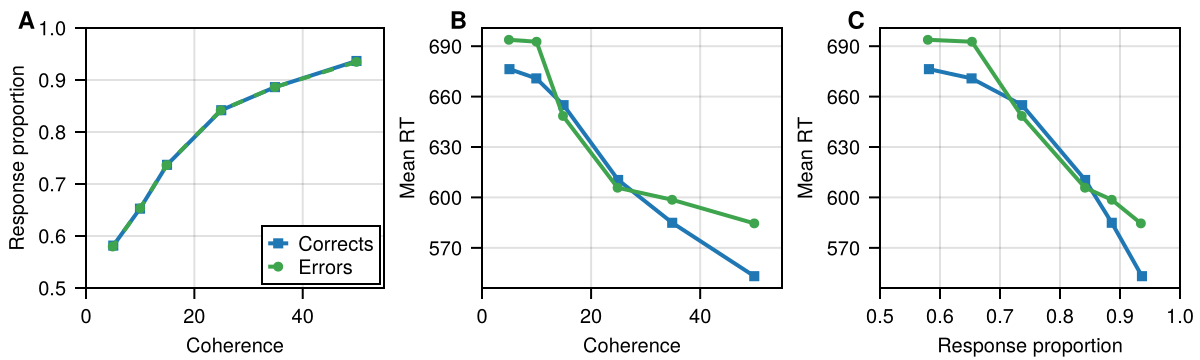

In [7]:
fig = Figure(size=(600, 180), fontsize=10, figure_padding=(3, 10, 3, 3)); ax = []; 
ga = fig[1,1] = GridLayout(); gb = fig[1,2] = GridLayout(); gc = fig[1,3] = GridLayout();
push!(ax, Axis(fig[1,1], xlabel="Coherence", ylabel="Response proportion", title=""));
push!(ax, Axis(fig[1,2], xlabel="Coherence", ylabel="Mean RT", title=""));
push!(ax, Axis(fig[1,3], xlabel="Response proportion", ylabel="Mean RT", title=""));
scatterlines!(ax[1], coh_cor, acc_cor, linewidth=2, markersize=8, marker=:rect, label="Corrects");
scatterlines!(ax[2], coh_cor,  RT_cor, linewidth=2, markersize=8, marker=:rect, label="Corrects");
scatterlines!(ax[3], acc_cor,  RT_cor, linewidth=2, markersize=8, marker=:rect, label="Corrects");
scatterlines!(ax[1], coh_err, acc_err, linewidth=2, markersize=7, label="Errors", linestyle=:dash);
scatterlines!(ax[2], coh_err,  RT_err, linewidth=2, markersize=7, label="Errors", );
scatterlines!(ax[3], acc_err,  RT_err, linewidth=2, markersize=7, label="Errors", );
colgap!(fig.layout, 7); xlims!(ax[1], 0, 55); xlims!(ax[2], 0, 55);
ylims!(ax[1], 0.5, 1); xlims!(ax[3], 0.5, 1);
ax[3].xticks = 0:0.1:1;     ax[1].yticks = 0:0.1:1;   
ax[1].xticks = -40:20:40;   #ax[2].yticks = 560:40:700;
ax[2].xticks = -40:20:40;   #ax[3].yticks = 560:40:700;
axislegend(ax[1], position=:rb, padding=(3,3,3,3), margin=(2,2,2,2), rowgap=0, patchsize=(10,6)) #, labelsize=8)
for (label, layout) in zip(["A", "B", "C"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
            fontsize = 12,
            font = :bold,
            padding = (label=="A") ? (0, 25, -3, 0) : (0, 8, -3, 0),
            halign = :right)
end
resize_to_layout!(fig)
fig

## Load IIM data from simulations for fitting

In [19]:
L = 40; # 40 10 100
IC = "ZERO"; #ZERO, RAND
ic = lowercase(IC);
file_name="./03_data_IIM_simulations/IIM1D_$(IC)_error_rt_vel_etas_0.0_1.0_Ts_0.01_0.85_bias_0.0_2.28_L_$(L)_iter_3000_234000"
df_raw = DataFrame(File(file_name*".csv"));
sort!(df_raw, [:eta, :T, :bias]);

In [9]:
## Choose the parameters T, eta for the IIM simulations

ηs_forquant = [0.38, 0.6, 0.1, 0.42, 0.46, ];
Ts_forquant = [0.28, 0.4, 0.3, 0.28, 0.20, ];

biases_forquant = []; acc_forquant = []; RTcRTw_forquant = []; biases_error_T1 = [];

for (ind, (η, T)) in enumerate(zip(ηs_forquant, Ts_forquant))
    println("T=$T, η=$η")
    df_eta = df_raw[df_raw.eta .== η, :];
        df_eta_T1 = df_eta[df_eta.T .== T, :]; 
        biases_error_T1 = [df_eta_T1[ findnearest(errors_data[ii], df_eta_T1.error), [:bias, :error, :rt_cw]] for ii in 1:length(errors_data)];
        push!(biases_forquant,  [el.bias for el in biases_error_T1]);
        push!(acc_forquant,[1 - el.error for el in biases_error_T1]);
        push!(RTcRTw_forquant, [el.rt_cw for el in biases_error_T1]);
end

T=0.28, η=0.38
T=0.4, η=0.6
T=0.3, η=0.1
T=0.28, η=0.42
T=0.2, η=0.46


## MSE heatmaps

In [10]:
#hmap
nummovmean = 3; # number of points for moving mean
min_length_sim = 7; # minimum number of points to fit the curve
Tmax_hmap = 0.56; # maximum temperature for the heatmap
etas_long = sort(unique(df_raw.eta))[1:2:end];
Ts_long   = sort(unique(df_raw.T  ))[2:2:end]; Ts_long = Ts_long[0.02 .≤ Ts_long .≤ Tmax_hmap];
derror = 0.015;

mse(x, y) = nanmean((x .- y).^2);
    MSE_normmeanRT_hmap = fill(NaN, length(Ts_long), length(etas_long));
    MSE_RTcRTw_hmap     = fill(NaN, length(Ts_long), length(etas_long));

err_data_for_RTnorm = 1-acc_meanRT[end];
    err_meanRTnorm_data = 1 .- acc_meanRT;
    meanRTnorm_data = meanRT_vec ./ meanRT_vec[end];
    err_RTcRTw_data = 1 .- acc_cor_err;
    RTcRTw_data = RTcRTw_data;

for (ind_η, η) in enumerate(etas_long)
    df_eta = df_raw[df_raw.eta .== η, :];
    for (ind_T, T) in enumerate(Ts_long)
        df_eta_T1 = df_eta[df_eta.T .== T, :]; 
            biases_error_T1 = df_eta_T1[:, [:bias, :error, :rt_cw, :rt]];
            biases_T1 = biases_error_T1.bias;
            err_T1    = biases_error_T1.error[biases_error_T1.error .≥ derror];
            RTcRTw_T1 = biases_error_T1.rt_cw;
            meanRT_T1 = biases_error_T1.rt;

        if length(err_T1) < min_length_sim continue end # skip if not enough data points
        perm = sortperm(err_T1); err_T1 = err_T1[perm]; biases_T1 = biases_T1[perm]; 
                RTcRTw_T1 = RTcRTw_T1[perm]; meanRT_T1 = meanRT_T1[perm];
        
        polyfit_power = 6; x = err_T1; y = meanRT_T1;
            fit_xy = curve_fit(Polynomial, x, y, polyfit_power);
            yfit_meanRTnorm = fit_xy.(err_meanRTnorm_data) ./ fit_xy.(err_data_for_RTnorm);
            mse_meanRTnorm = mse(yfit_meanRTnorm, meanRTnorm_data);
            MSE_normmeanRT_hmap[ind_T, ind_η] = mse_meanRTnorm;
        
        polyfit_power = 4; x = err_T1; y = RTcRTw_T1;
            fit_xy = curve_fit(Polynomial, x, y, polyfit_power);
            yfit_RTcRTw = fit_xy.(err_RTcRTw_data);
            mse_RTcRTw = mse(yfit_RTcRTw, RTcRTw_data);
            MSE_RTcRTw_hmap[ind_T, ind_η] = mse_RTcRTw;
    
    end
end

In [11]:
## Find best fit
inds_bestfit = intersect(findall(MSE_normmeanRT_hmap .< 0.0035), findall(MSE_RTcRTw_hmap .< 0.00045))

T_bestfit = Ts_long[inds_bestfit[1][1]];
η_bestfit = etas_long[inds_bestfit[1][2]];

T_bestfit, η_bestfit, inds_bestfit

(0.2, 0.46, CartesianIndex{2}[CartesianIndex(10, 24)])

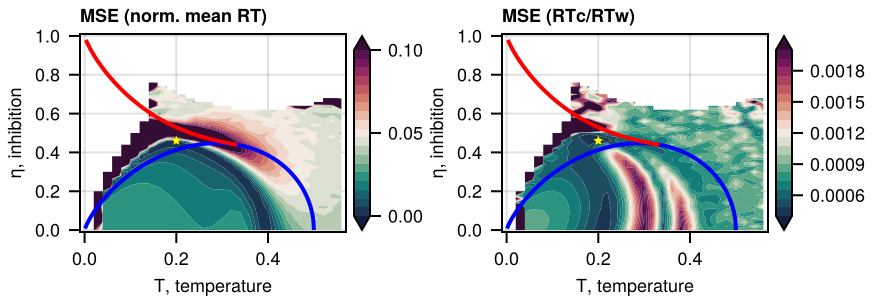

In [12]:
fig = Figure(size=(220*2, 150*1), fontsize=9, figure_padding=(3,8,3,3)); ax = []; gxvec = [];
ga = fig[1,1] = GridLayout(); gb = fig[1,2] = GridLayout();
    push!(ax, Axis(ga[1,1], xlabel="T, temperature", ylabel="η, inhibition", titlealign = :left, title="MSE (norm. mean RT)"));
    push!(ax, Axis(gb[1,1], xlabel="T, temperature", ylabel="η, inhibition", titlealign = :left, title="MSE (RTc/RTw)"));
cmap = :curl; cf = [];  
push!(cf, contourf!(ax[1], Ts_long, etas_long, MSE_normmeanRT_hmap, levels=range(0,      0.1,   length=20), extendlow=:auto, extendhigh=:auto, colormap=cmap ))  # levels=range(0,      0.016,  length=20), 
push!(cf, contourf!(ax[2], Ts_long, etas_long, MSE_RTcRTw_hmap,     levels=range(0.0004, 0.002, length=20), extendlow=:auto, extendhigh=:auto, colormap=cmap ))  # levels=range(0.0004, 0.0007, length=20), 
Colorbar(ga[1,2], cf[1], width = 8)
Colorbar(gb[1,2], cf[2], width = 8)

for axi in ax 
    lines!(axi, Tblue, ηblue, linewidth=2, color=:blue)
    lines!(axi, Tred,  ηred,  linewidth=2, color=:red )
    xlims!(axi, -0.01, Tmax_hmap+0.01);   ylims!(axi, -0.01, 1.01); axi.yticks = 0:0.2:1;
end
[scatter!(axi, [T_bestfit], [η_bestfit], marker=:star5, markersize=6, color=:yellow, strokewidth=0.1) for axi in ax]
colgap!(fig.layout, 4); rowgap!(fig.layout, 4);  
rowgap!(ga, 4);  colgap!(ga, 4); 
rowgap!(gb, 4);  colgap!(gb, 4); 
resize_to_layout!(fig);
fig

## Final plot

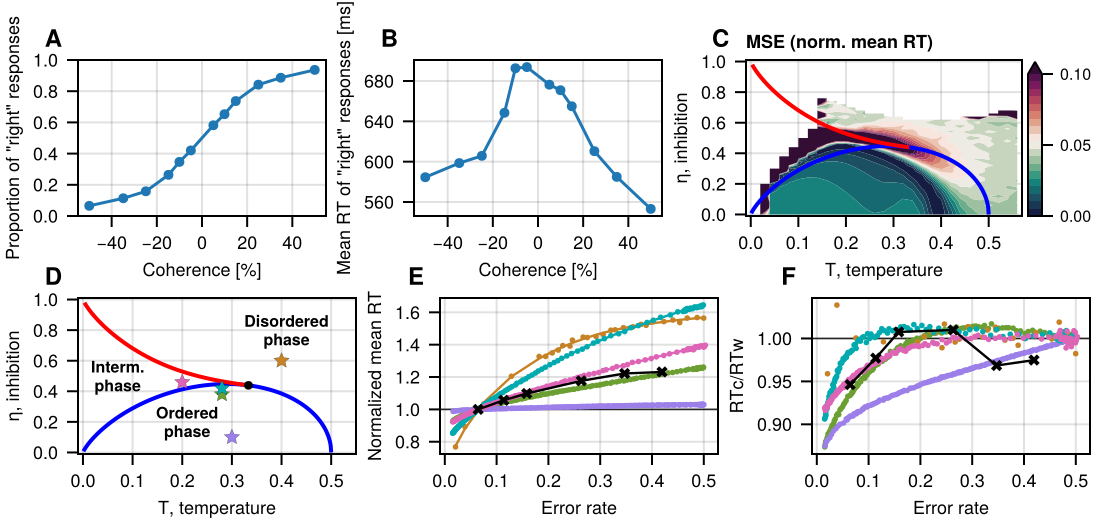

In [13]:
etas = ηs_forquant;
Ts   = Ts_forquant;
colors = c[[16, 8, 12, 6,  15,    4,]];
nummovemean=1;    derror = 0.015;

fig = Figure(size=(550, 260), fontsize=9, figure_padding=(2, 5, 2, 12)); ax = []; 
    gabc = fig[1,1:3] = GridLayout()
    ga = gabc[1,1] = GridLayout(); gb = gabc[1,2] = GridLayout(); gc = gabc[1,3] = GridLayout();
    gdef = fig[2,1:3] = GridLayout()
    gd = gdef[1,1] = GridLayout(); ge = gdef[1,2] = GridLayout(); gf = gdef[1,3] = GridLayout();
    push!(ax, Axis(ga[1,1], xlabel="Coherence [%]",  ylabel="Proportion of \"right\" responses",  title="")); #, yticklabelcolor=c[1]));
    push!(ax, Axis(gb[1,1], xlabel="Coherence [%]",  ylabel="Mean RT of \"right\" responses [ms]",     title="")); #, yticklabelcolor=c[4], yaxisposition = :right));
    push!(ax, Axis(gc[1,1], xlabel="T, temperature", ylabel="η, inhibition", titlealign = :left, title="MSE (norm. mean RT)"));
    push!(ax, Axis(gd[1,1], xlabel="T, temperature", ylabel="η, inhibition",                  title="")) #aspect = AxisAspect(1.5)));
    push!(ax, Axis(ge[1,1], xlabel="Error rate", ylabel="Normalized mean RT",                 title=""));
    push!(ax, Axis(gf[1,1], xlabel="Error rate", ylabel="RTc/RTw",                            title=""));

if true ## A B data from paper
    scatterlines!(ax[1], coherence, accuracy, linewidth=1.5, color=c[1], markersize=7, marker=:circle, label="Corrects");
    scatterlines!(ax[2], coherence, RTmean,   linewidth=1.5, color=c[1], markersize=7, marker=:circle, label="Corrects");
    ax[1].xticks = -40:20:40;   ax[1].yticks = 0:0.2:1;  ylims!(ax[1], 0, 1);
    ax[2].xticks = -40:20:40;   ax[2].yticks = 560:40:700;  
end
if true ## C heatmap MSE
    cmap = :curl; cf = [];              
    push!(cf, contourf!(ax[3], Ts_long, etas_long, MSE_normmeanRT_hmap, extendhigh=:auto, colormap=cmap, levels=range(0, 0.1, length=20) ))  # colorrange = (0, 1), 
    Colorbar(gabc[1,4], cf[1], width = 7, ticklabelsize=8, alignmode = Outside())#, ticks=0.0:0.2:1,  height=120, tellheight=true)#, height=120, tellheight=false); 
    lines!(ax[3], Tblue, ηblue, linewidth=2, color=:blue)     # 0.1,       0.016, 
    lines!(ax[3], Tred,  ηred,  linewidth=2, color=:red )     # 0.002,     0.00075,
    xlims!(ax[3], -0.01, Tmax_hmap+0.01);   ylims!(ax[3], -0.01, 1.01); ax[3].yticks = 0:0.2:1; ax[3].xticks = 0:0.1:1;
end
if true ## D phase diagram
    lines!(  ax[4], Tblue, ηblue, color=:blue, linewidth=2);
    lines!(  ax[4], Tred,  ηred,  color=:red,  linewidth=2);
    scatter!(ax[4], [Tcritpoint],[ηcritpoint], marker=:circle, markersize=6, color=:black, strokewidth=0.1);
    [scatter!(ax[4], [T], [η], markersize=9, marker=:star5, color=colors[indηT], strokewidth=0.1, label="T=$T, η=$η") 
        for (indηT, (η, T)) in enumerate(zip(etas, Ts))];
    text!(   ax[4], [0.07, 0.21, 0.41], [0.5, 0.2, 0.8], text=["Interm.\nphase", "Ordered\nphase", "Disordered\nphase"], 
                color=:black, font=:bold, fontsize=8, align=(:center, :center)) #font=:bold,
    xlims!(  ax[4], [-0.01, 0.55]);  ax[4].xticks = 0:0.1:1;
    ylims!(  ax[4], [-0.01, 1.01]);  ax[4].yticks = 0:0.2:1;
end
if true  ## E F defined eta T   IIM vs data mean RT and RTc/RTw
    hlines!(ax[5], [1], color=:grey15, linewidth=0.8);
    hlines!(ax[6], [1], color=:grey15, linewidth=0.8);  
    for (indηT, (η, T)) in enumerate(zip(etas, Ts))
        df_eta = df_raw[df_raw.eta .== η, :];
            df_eta_T1 = df_eta[df_eta.T .== T, :]; 
            biases_error_T1 = df_eta_T1[:, [:bias, :error, :rt_cw, :rt]];
            biases_T1 = biases_error_T1.bias;
            err_T1    = biases_error_T1.error[biases_error_T1.error .≥ derror];
            RTcRTw_T1 = biases_error_T1.rt_cw;
            meanRT_T1 = biases_error_T1.rt;
            perm = sortperm(err_T1); err_T1 = err_T1[perm]; biases_T1 = biases_T1[perm]; 
                RTcRTw_T1 = RTcRTw_T1[perm]; meanRT_T1 = meanRT_T1[perm];
        if true || η > Fblue(T)   
            polyfit_power = 6;
            x = err_T1; y = meanRT_T1;
            fit_xy = curve_fit(Polynomial, x, y, polyfit_power);
            yfit = fit_xy.(x) ./ fit_xy.(err_data_for_RTnorm); ## normalize RT by the first point
            lines!(ax[5], x, yfit, linewidth=1.2, color=colors[indηT]); 
            meanRT_T1_norm = meanRT_T1 ./ fit_xy.(err_data_for_RTnorm);
        else
            meanRT_T1_norm = meanRT_T1 ./ meanRT_T1[findnearest(err_data_for_RTnorm, err_T1)];
        end   
        #meanRT_T1_norm = meanRT_T1 ./ meanRT_T1[findnearest(err_data_for_RTnorm, err_T1)];                 
        scatterlines!(ax[5], err_T1, movmean(meanRT_T1_norm, nummovemean), markersize=4, linewidth=0, color=colors[indηT], label="T=$T");
        scatterlines!(ax[6], err_T1, movmean(RTcRTw_T1,      nummovemean), markersize=4, linewidth=0, color=colors[indηT], label="T=$T");
    end

    scatterlines!(ax[5], err_meanRTnorm_data, meanRTnorm_data, linewidth=1.2, markersize=8, marker=:xcross, color=:black);
    scatterlines!(ax[6], err_RTcRTw_data,     RTcRTw_data,     linewidth=1.2, markersize=8, marker=:xcross, color=:black);
    ax[5].xticks = 0:0.1:1;
    ax[6].xticks = 0:0.1:1;
end
if true for (label, layout) in zip(["A", "B", "C", "D", "E", "F"], [ga, gb, gc, gd, ge, gf])
    Label(layout[1, 1, TopLeft()], label,
            fontsize = 12,
            font = :bold,
            padding = (0, 8, 4, 0),
            halign = :right)
end end
colgap!(fig.layout, 0); rowgap!(fig.layout, -8); 
    colgap!(gabc, 5); colgap!(gdef, 5); colgap!(gabc, 3, 3);
    #colsize!(gabc, 1, Relative(0.3333)); colsize!(gabc, 2, Relative(0.3333))
    colsize!(gabc, 3, Relative(0.3333));
    resize_to_layout!(fig)
fig

## Load data for RT quantiles

In [14]:
quantiles = 0.1:0.2:0.9;
file_name="./05_data_RDM/D_RT_quantiles_data";
df = DataFrame(File(file_name*".csv"));
accuracy_D  = df[:, 1]; RT_quant = df[:, 2];
df = nothing;

npoints = Int8(length(accuracy_D)/length(quantiles));
accuracy_mean_D = mean(reshape(accuracy_D, length(quantiles), npoints), dims=1)[:];
RT_quant_per_acc = reshape(RT_quant, length(quantiles), npoints)
[accuracy_mean_D 1 .- accuracy_mean_D]

acc_D_positive = accuracy_mean_D[accuracy_mean_D .≥ 0.5];
errors_D_positive = 1 .- acc_D_positive;
errors_D_negative = accuracy_mean_D[accuracy_mean_D .≤ 0.5];
acc_D_negative = 1 .- errors_D_negative;

RT_quant_per_acc_vec = [col[:] for col in eachcol(RT_quant_per_acc)];
RT_quant_pos = RT_quant_per_acc_vec[accuracy_mean_D .≥ 0.5];
RT_quant_neg = RT_quant_per_acc_vec[accuracy_mean_D .≤ 0.5];

RT_quant_per_acc_vec_norm = [el ./ el[quantiles .== 0.5] for el in RT_quant_per_acc_vec];
RT_quant_pos_norm = [el ./ el[quantiles .== 0.5] for el in RT_quant_pos];
RT_quant_neg_norm = [el ./ el[quantiles .== 0.5] for el in RT_quant_neg];

## Load IIM data for RT quantiles

In [15]:
filename ="./03_data_IIM_simulations/simulations_eta0.380.60.10.420.46_T0.280.40.30.280.2_iter50000.jld";
IIM_data_RTquant = load(filename)

Dict{String, Any} with 2 entries:
  "parameters" => Vector{Any}[[0.38, 0.28, 0.009, 50000, 0.1:0.2:0.9], [0.38, 0…
  "raw_sim"    => [(0.38, 0.28, 0.009, 50000, 0.41506, [245.776, 184.921, 97.43…

In [16]:
raw_sim = IIM_data_RTquant["raw_sim"];
etas_sim   = Float64[el[1] for el in raw_sim];
Ts_sim     = Float64[el[2] for el in raw_sim];
biases_sim = Float64[el[3] for el in raw_sim];
iters_sim  =   Int64[el[4] for el in raw_sim];
errors_sim = Float64[el[5] for el in raw_sim];
rts_sim    =        [el[6] for el in raw_sim];
rts_cor_sim =       [el[7] for el in raw_sim];
rts_err_sim =       [el[8] for el in raw_sim];
quantiles_cor_sim = [el[9] for el in raw_sim];
quantiles_err_sim = [el[10] for el in raw_sim];

biases_sim_by_eta = [biases_sim[etas_sim .== η] for η in ηs_forquant];
errors_sim_by_eta = [errors_sim[etas_sim .== η] for η in ηs_forquant];
quantiles_cor_sim_by_eta = [quantiles_cor_sim[etas_sim .== η] for η in ηs_forquant];
quantiles_err_sim_by_eta = [quantiles_err_sim[etas_sim .== η] for η in ηs_forquant];
rts_sim_by_eta = [rts_sim[etas_sim .== η] for η in ηs_forquant];
rts_cor_sim_by_eta = [rts_cor_sim[etas_sim .== η] for η in ηs_forquant];
rts_err_sim_by_eta = [rts_err_sim[etas_sim .== η] for η in ηs_forquant];

acc_sim_by_eta = [[reverse(el); 1 .- el] for el in errors_sim_by_eta];
quantplot = [[reverse(elneg); elpos] for (elneg, elpos) in zip(quantiles_err_sim_by_eta, quantiles_cor_sim_by_eta)];

quant_plot_with_lines = [[[el_eta[jj][ii] for jj in 1:length(el_eta)] for ii in 1:length(quantiles)] for el_eta in quantplot]
quant_plot_with_lines_cor = [[[el_eta[jj][ii] for jj in 1:length(el_eta)] for ii in 1:length(quantiles)] for el_eta in quantiles_cor_sim_by_eta]
quant_plot_with_lines_err = [[[el_eta[jj][ii] for jj in 1:length(el_eta)] for ii in 1:length(quantiles)] for el_eta in quantiles_err_sim_by_eta]

meanRT_sim = [mean(el) for el in rts_sim];
meanRTcor_sim = [mean(el) for el in rts_cor_sim];
meanRTerr_sim = [mean(el) for el in rts_err_sim];
acc_sim = 1 .- errors_sim;

ind=3 ii=1 etas[ind]=0.1 Ts[ind]=0.3
ind=5 ii=2 etas[ind]=0.46 Ts[ind]=0.2
ind=1 ii=3 etas[ind]=0.38 Ts[ind]=0.28
ind=4 ii=4 etas[ind]=0.42 Ts[ind]=0.28
ind=2 ii=5 etas[ind]=0.6 Ts[ind]=0.4


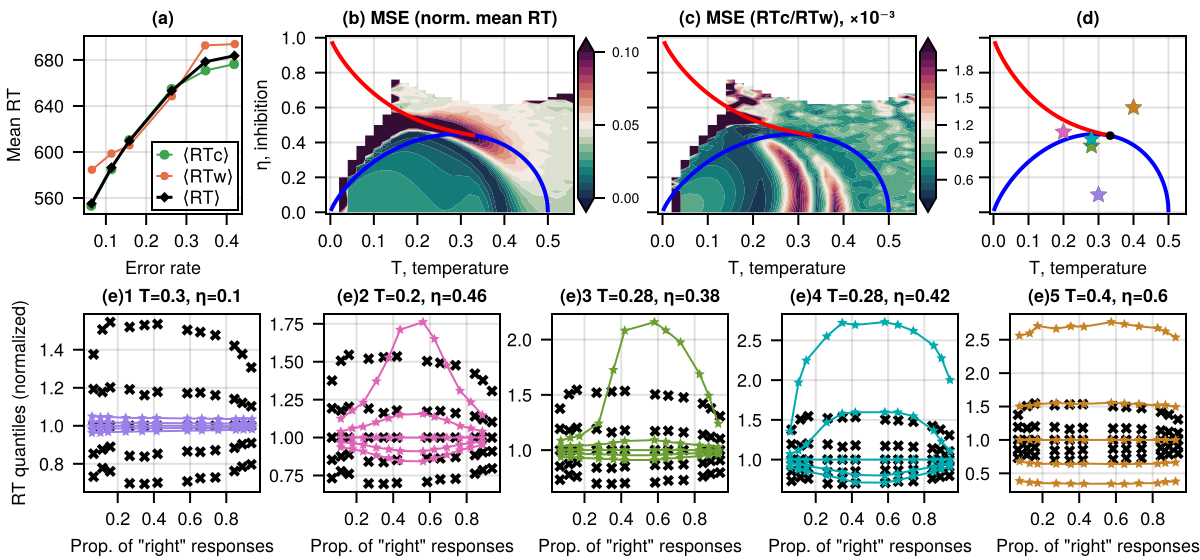

In [17]:
#etas = [0.4, 0.38, 0.6, 0.1, 0.42,]; Ts = [0.5, 0.28, 0.4, 0.3, 0.28, ]; colors = c[[15, 16, 8, 12, 6, 12, 4]];
ind_point = [3, 5, 1, 4, 2];  #reorder stars

fig = Figure(size=(600, 280), fontsize=9, figure_padding=(3, 7, 3, 3)); ax = []; 
    gtop = fig[1,1:5] = GridLayout()
    g11 = gtop[1,1] = GridLayout(); g12 = gtop[1,2] = GridLayout(); g13 = gtop[1,3] = GridLayout(); g14 = gtop[1,4] = GridLayout();
    gbot = fig[2,1:5] = GridLayout()
    g21 = gbot[1,1] = GridLayout(); g22 = gbot[1,2] = GridLayout(); g23 = gbot[1,3] = GridLayout(); g24 = gbot[1,4] = GridLayout(); g25 = gbot[1,5] = GridLayout();
    push!(ax, Axis(g11[1,1], xlabel="Error rate",     ylabel="Mean RT",       title="(a)"));
    push!(ax, Axis(g12[1,1], xlabel="T, temperature", ylabel="η, inhibition", title="(b) MSE (norm. mean RT)")) ;  ## titlealign = :left, 
    push!(ax, Axis(g13[1,1], xlabel="T, temperature", ylabel="",              title="(c) MSE (RTc/RTw), ×10⁻³"));  ## titlealign = :left, 
    push!(ax, Axis(g14[1,1], xlabel="T, temperature", ylabel="",              title="(d)")) #aspect = AxisAspect(1.5)));
    push!(ax, Axis(g21[1,1], xlabel="Prop. of \"right\" responses", ylabel="RT quantiles (normalized)",title="(e)1 T=$(Ts[ind_point[1]]), η=$(etas[ind_point[1]])"));
    push!(ax, Axis(g22[1,1], xlabel="Prop. of \"right\" responses", ylabel="",                         title="(e)2 T=$(Ts[ind_point[2]]), η=$(etas[ind_point[2]])"));
    push!(ax, Axis(g23[1,1], xlabel="Prop. of \"right\" responses", ylabel="",                         title="(e)3 T=$(Ts[ind_point[3]]), η=$(etas[ind_point[3]])"));
    push!(ax, Axis(g24[1,1], xlabel="Prop. of \"right\" responses", ylabel="",                         title="(e)4 T=$(Ts[ind_point[4]]), η=$(etas[ind_point[4]])"));
    push!(ax, Axis(g25[1,1], xlabel="Prop. of \"right\" responses", ylabel="",                         title="(e)5 T=$(Ts[ind_point[5]]), η=$(etas[ind_point[5]])"));
    [hideydecorations!(axi, label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false) for axi in ax[3:4]]

if true # data from paper RTc RTw
    scatterlines!(ax[1], 1 .- acc_cor,          RT_cor,          markersize=7, linewidth=1,   color=c[2],   label="⟨RTc⟩", );
    scatterlines!(ax[1], 1 .- reverse(acc_err), reverse(RT_err), markersize=6, linewidth=1,   color=c[3],   label="⟨RTw⟩", );
    scatterlines!(ax[1], 1 .- acc_meanRT,       meanRT_vec,      markersize=6, linewidth=1.5, color=:black, label="⟨RT⟩",  marker=:diamond); 
    ax[1].yticks = 560:40:700;
    axislegend(ax[1], position=:rb, padding=(2,2,1,1), margin=(2,2,2,2), rowgap=0, patchsize=(8,6)) #, labelsize=8)
end
if true ## heatmap MSE RTcRTw
    cf=[]; cmap = :curl;
    push!(cf, contourf!(ax[2], Ts_long, etas_long, MSE_normmeanRT_hmap .* 10^0, levels=10^0 .* range(0,      0.1,   length=20), extendlow=:auto, extendhigh=:auto, colormap=cmap, ))  # colorrange = (0, 1), 
    push!(cf, contourf!(ax[3], Ts_long, etas_long, MSE_RTcRTw_hmap     .* 10^3, levels=10^3 .* range(0.0004, 0.002, length=20), extendlow=:auto, extendhigh=:auto, colormap=cmap, ))  # colorrange = (0, 1), 
    Colorbar(g12[1,2], cf[1], width = 8, ticklabelsize=7, alignmode = Outside())#, ticks=0.0:0.2:1,  height=120, tellheight=true)#, height=120, tellheight=false); 
    Colorbar(g13[1,2], cf[2], width = 8, ticklabelsize=7, alignmode = Outside())#, ticks=0.0:0.2:1,  height=120, tellheight=true)#, height=120, tellheight=false); 
    for axi in ax[2:3]
        lines!(axi, Tblue, ηblue, linewidth=2, color=:blue)    # 0.1,       0.016, 
        lines!(axi, Tred,  ηred,  linewidth=2, color=:red )    # 0.002,     0.00075,
        xlims!(axi, -0.01, 0.56);   ylims!(axi, -0.01, 1.01); axi.yticks = 0:0.2:1; axi.xticks = 0:0.1:1; 
    end
end
if true ## phase diagram
    lines!(  ax[4], Tblue, ηblue, color=:blue, linewidth=2);
    lines!(  ax[4], Tred,  ηred,  color=:red,  linewidth=2);
    scatter!(ax[4], [Tcritpoint],[ηcritpoint], marker=:circle, markersize=6, color=:black, strokewidth=0.1);
    #text!(   ax[4], [0.07, 0.21, 0.41], [0.5, 0.2, 0.8], text=["Interm.\nphase", "Ordered\nphase", "Disordered\nphase"], color=:black, font=:bold, fontsize=8, align=(:center, :center)) #font=:bold,
    xlims!(  ax[4], [-0.01, 0.55]);  ax[4].xticks = 0:0.1:1;
    ylims!(  ax[4], [-0.01, 1.01]);  ax[4].yticks = 0:0.2:1;
    scatter!(ax[4], Ts[ind_point], etas[ind_point], marker=:star5, markersize=10, color=colors[ind_point], strokewidth=0.1);
    
end
if true ## RT quantiles vs response proportion
    ind_axPP = 4;
    for (ii, ind) in enumerate(ind_point)
        println("ind=", ind, " ii=", ii, " etas[ind]=", etas[ind], " Ts[ind]=", Ts[ind])
        η, T = etas[ind], Ts[ind]; 
        [scatter!(ax[ii+ind_axPP], acc*ones(length(RTquant)), RTquant, markersize=8, marker=:xcross, color=:black) for (acc, RTquant) in zip(accuracy_mean_D, RT_quant_per_acc_vec_norm)];
        [scatterlines!(ax[ii+ind_axPP], acc_sim_by_eta[ii], quantile_line, markersize=6, color=colors[ind], marker=:star5, linewidth=1) 
            for quantile_line in quant_plot_with_lines[ind]];
        ax[ii+ind_axPP].xticks = 0:0.2:1;
    end
end
colgap!(fig.layout, -5); rowgap!(fig.layout, 4); resize_to_layout!(fig);
colgap!(gtop, 5); colgap!(gbot, 5); colgap!(g12, 2); colgap!(g13, 2);
colsize!(gtop, 2, Relative(0.32));
colsize!(gtop, 3, Relative(0.32));
colsize!(gtop, 4, Relative(0.20));
fig